In [79]:
from typing import List, Dict, Any
import argparse
import pickle
import datetime
import pandas as pd
from lib.read_data import read_data
from lib.read_data_2015 import read_data_2015
from lib.consts import get_lgb_params_base, get_n_folds
from lib.data_series import prepare_data_serie, DataSerie
from lib.train import train_data_series, train_fold
from lib.data_filter import DataFilter
from lib.kernels import TherapyPredictorFactory, prepare_therapy_models
from lib.metrics import RMSE
from lib.visit_model import (
    VisitModelDescription,
    VisitModel,
    get_basic_info_as_str,
    get_start_protocol_visit_cols,
    get_start_stimulation_visit_cols,
    get_genetic_cols,
    save_model,
    get_visit_model_filename,
)
from lib.vcf import (
    read_vcf_files,
    LocusInfo,
    SnipInfo,
    Genome,
    GeneticData,
    prepare_genome_df,
    prepare_hmap_files,
    prepare_phase_files,
    read_mappings,
    read_allele_file,
    prepare_genetic_data,
    read_vcf_files_list,
    read_file_list,
)
from lib.read_haplotypes import (
    read_phase_inp_files,
    read_fastphase_files,
    read_phase_files,
    read_haploview_column,
    read_haploview_data,
    read_haploview_file,
    read_hmap_file,
)
import os
from sklearn.metrics import auc, roc_curve

from lib.notebook_imports import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from dotenv import load_dotenv
load_dotenv()
DATA_PATH = os.environ.get("DATA_PATH")

In [ ]:
    # Read data
data_900_df = read_data(
    DATA_PATH,
    merge_with_meds=True,
    merge_with_patient_genes=True,
).input_df
data_2015_df = read_data_2015(DATA_PATH)

genetic_data = read_vcf_files(
    DATA_PATH,
    DATA_PATH + "/vcf/",
)
(
    genome_df,
    genome_012_cols,
    hetero_cols,
    homo_cols,
    has_alt_cols,
) = prepare_genome_df(genetic_data)
print(f"before merge: {len(data_900_df)}")
data_900_df = data_900_df.merge(
    genome_df, left_on="__id__", right_on="patient_id", how="inner"
)
print(f"after merge:  {len(data_900_df)}")
chromosomes = [
    "chr11",
    "chr12",
    "chr14",
    "chr17",
    "chr19",
    "chr2",
    "chr5",
    "chr6",
    "chrX",
]
methods = ["GABRIEL", "4GAM", "SPINE"]
data_900_df, all_block_cols = read_haploview_data(
    DATA_PATH + "/poprawne_vcf_haplotypes/haplotypes/hmap",
    chromosomes,
    methods,
    data_900_df,
)
data_900_df["SOM_cols"] = data_900_df[
    [
        "GDF9_5_132865538_T_C",
        "GDF9_5_132866205_T_C",
        "PRL_6_22292747_A_T",
        "AR_X_67723521_-_CACACAC",
        "LHCGR_2_48729336_C_T",
        "FSHB_11_30234435_A_G",
        "ESR1_6_152061190_A_G",
        "ESR2_14_64227477_C_T",
    ]
].sum(axis=1)
data_900_df["chr2_4GAM_block4_haplotypes_variants"] = (
    (data_900_df["genome_012_chr2_48962782_C_T"] > 0)
    & (data_900_df["genome_012_chr2_48962060_A_G"] == 0)
) * 1
data_900_df["chr5_4GAM_block2_haplotypes_variants"] = (
    (
        data_900_df.loc[
            :,
            [
                "genome_012_chr5_35063190_A_T",
                "genome_012_chr5_35064922_C_G",
                "genome_012_chr5_35068146_G_C",
                "genome_012_chr5_35061629_T_C",
                "genome_012_chr5_35069864_G_A",
                "genome_012_chr5_35064413_C_A",
                "genome_012_chr5_35062516_C_T",
                "genome_012_chr5_35065548_C_T",
            ],
        ].sum(axis=1)
        == 0
    )
) * 1
col_map = {
    column_value: column_number
    for column_number, column_value in enumerate(['prot_long','prot_short_agonist','prot_short_antagonista','prot_progesteron','prot_other'])
}
data_900_df['prot_type_cat'] = data_900_df['prot_type'].map(col_map).astype('category')
data_2015_df['prot_type_cat'] = data_2015_df['prot_type'].map(col_map).astype('category')


# Data 900

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


-
RMSE[ test_fold_avg][h20][day_0_mii]:          count:516    avg:5.92   nan    (nan)    
MAE[ test_fold_avg][h20][day_0_mii]:           count:516    avg:5.92   nan    (nan)    
MAPE[ test_fold_avg][h20][day_0_mii]:          count:516    avg:5.92   nan    (nan)    
LIKELIHOOD[ test_fold_avg][h20][day_0_mii]:    count:516    avg:5.92   0.82    (0.00)    
-----------------------------
AUC:0.9185585826210826


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


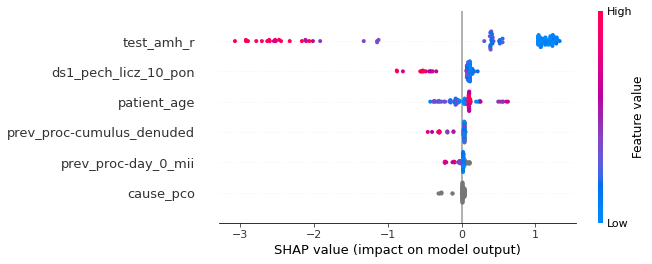

In [107]:
train_cols = [
        "test_amh_r",
        "patient_age",
        "ds1_pech_licz_10_pon",
        "prev_proc-cumulus_denuded",
        "prev_proc-day_0_mii",
        'cause_pco'
    ]

GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    train_cols,
    model_suffixes_filter=['h20'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['h20'],
    print_avg=True,
)
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['hiper_20']-GENE_RESULTS_df['prediction_h20']
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('day_0_mii').copy()
fpr, tpr, thresholds = roc_curve(GENE_RESULTS_df['hiper_20'],GENE_RESULTS_df['prediction_h20'], pos_label=1)
print('AUC:{}'.format(auc(fpr, tpr)))
explainer = shap.TreeExplainer(GENE_RESULTS.train_infos['day_0_mii'].fold_infos[0].lgb_models['h20'])
shap_values = explainer.shap_values(GENE_RESULTS.train_infos['day_0_mii'].fold_infos[0].test_df[train_cols])
shap.summary_plot(shap_values[0], GENE_RESULTS.train_infos['day_0_mii'].fold_infos[0].test_df[train_cols])

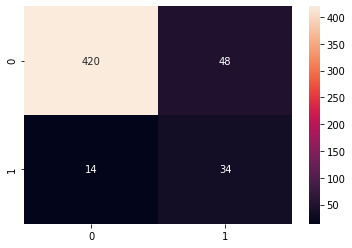

-----------------------
TEST
Confusion Matrix
[[420  48]
 [ 14  34]]
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       468
           1       0.41      0.71      0.52        48

    accuracy                           0.88       516
   macro avg       0.69      0.80      0.73       516
weighted avg       0.92      0.88      0.89       516

Accuracy = 0.8798449612403101
AUC = 0.9185585826210826


In [108]:
y_tests = GENE_RESULTS_df['hiper_20']
y_predicted_test = (GENE_RESULTS_df['prediction_h20']>0.2)*1
predictions_test = GENE_RESULTS_df['prediction_h20']
c = confusion_matrix(y_tests, y_predicted_test)
df_cm = pd.DataFrame(c)
sns.heatmap(c, annot=True, fmt='g')
plt.show()
print('-----------------------')
print('TEST')
print('Confusion Matrix')
print(confusion_matrix(y_tests, y_predicted_test))
print('Classification Report')
print(classification_report(y_tests, y_predicted_test))
print('Accuracy = '+ str(accuracy_score(y_tests, y_predicted_test)))
print('AUC = {}'.format(auc(fpr, tpr)))

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


-
RMSE[ test_fold_avg][h20][day_0_mii]:          count:516    avg:5.92   nan    (nan)    
MAE[ test_fold_avg][h20][day_0_mii]:           count:516    avg:5.92   nan    (nan)    
MAPE[ test_fold_avg][h20][day_0_mii]:          count:516    avg:5.92   nan    (nan)    
LIKELIHOOD[ test_fold_avg][h20][day_0_mii]:    count:516    avg:5.92   0.83    (0.00)    
-----------------------------
AUC:0.9171785968660969


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


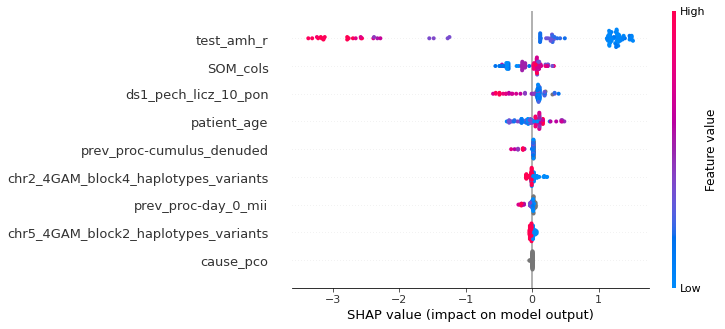

In [109]:
train_cols = [
        "test_amh_r",
        "patient_age",
        "ds1_pech_licz_10_pon",
        "prev_proc-cumulus_denuded",
        "prev_proc-day_0_mii",
        "cause_pco",
        'SOM_cols',
        'chr2_4GAM_block4_haplotypes_variants',
        'chr5_4GAM_block2_haplotypes_variants'
    ]

GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    train_cols,
    model_suffixes_filter=['h20'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['h20'],
    print_avg=True,
)
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['hiper_20']-GENE_RESULTS_df['prediction_h20']
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('day_0_mii').copy()
fpr, tpr, thresholds = roc_curve(GENE_RESULTS_df['hiper_20'],GENE_RESULTS_df['prediction_h20'], pos_label=1)
print('AUC:{}'.format(auc(fpr, tpr)))
explainer = shap.TreeExplainer(GENE_RESULTS.train_infos['day_0_mii'].fold_infos[0].lgb_models['h20'])
shap_values = explainer.shap_values(GENE_RESULTS.train_infos['day_0_mii'].fold_infos[0].test_df[train_cols])
shap.summary_plot(shap_values[0], GENE_RESULTS.train_infos['day_0_mii'].fold_infos[0].test_df[train_cols])

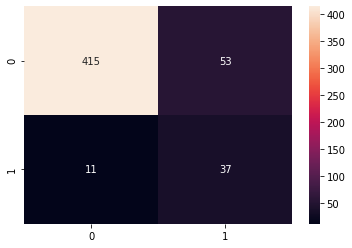

-----------------------
TEST
Confusion Matrix
[[415  53]
 [ 11  37]]
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       468
           1       0.41      0.77      0.54        48

    accuracy                           0.88       516
   macro avg       0.69      0.83      0.73       516
weighted avg       0.92      0.88      0.89       516

Accuracy = 0.875968992248062
AUC = 0.9171785968660969


In [110]:
y_tests = GENE_RESULTS_df['hiper_20']
y_predicted_test = (GENE_RESULTS_df['prediction_h20']>0.2)*1
predictions_test = GENE_RESULTS_df['prediction_h20']
c = confusion_matrix(y_tests, y_predicted_test)
df_cm = pd.DataFrame(c)
sns.heatmap(c, annot=True, fmt='g')
plt.show()
print('-----------------------')
print('TEST')
print('Confusion Matrix')
print(confusion_matrix(y_tests, y_predicted_test))
print('Classification Report')
print(classification_report(y_tests, y_predicted_test))
print('Accuracy = '+ str(accuracy_score(y_tests, y_predicted_test)))
print('AUC = {}'.format(auc(fpr, tpr)))

<AxesSubplot:xlabel='cumulus_count', ylabel='prediction_h20'>

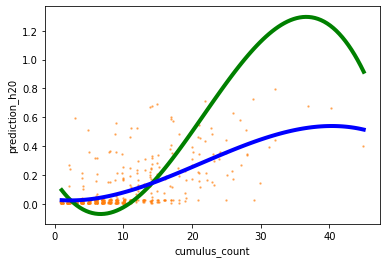

In [111]:
sns.regplot(
    y="hiper_20", 
    x="cumulus_count",    
    data=GENE_RESULTS_df,
    x_jitter=.2,
    ci = 1,
    scatter_kws={"s": 0,
    'alpha':0.5},
    line_kws={'lw':4,
    'color':'green'},
    order=3)
sns.regplot(
    y="prediction_h20", 
    x="cumulus_count",    
    data=GENE_RESULTS_df,
    x_jitter=.2,
    ci = 1,
    scatter_kws={"s": 2,
    'alpha':0.5},
    line_kws={'lw':4,
    'color':'blue'},
    order=3)

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


-
RMSE[ test_fold_avg][h20][day_0_mii]:          count:516    avg:5.92   nan    (nan)    
MAE[ test_fold_avg][h20][day_0_mii]:           count:516    avg:5.92   nan    (nan)    
MAPE[ test_fold_avg][h20][day_0_mii]:          count:516    avg:5.92   nan    (nan)    
LIKELIHOOD[ test_fold_avg][h20][day_0_mii]:    count:516    avg:5.92   0.82    (0.00)    
-----------------------------
AUC:0.89926103988604


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


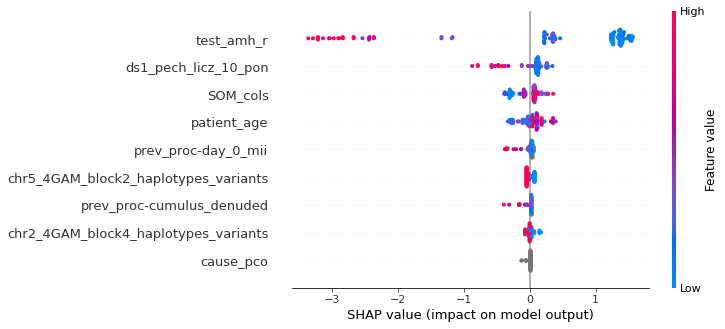

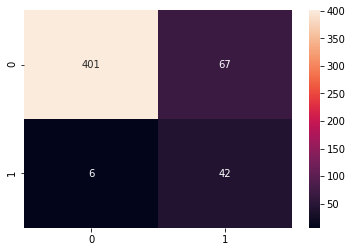

-----------------------
TEST
Confusion Matrix
[[401  67]
 [  6  42]]
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       468
           1       0.39      0.88      0.54        48

    accuracy                           0.86       516
   macro avg       0.69      0.87      0.73       516
weighted avg       0.93      0.86      0.88       516

Accuracy = 0.8585271317829457
AUC = 0.89926103988604


<AxesSubplot:xlabel='cumulus_count', ylabel='prediction_h20'>

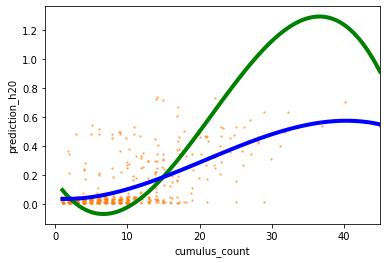

In [115]:
train_cols = [
        "test_amh_r",
        "patient_age",
        "ds1_pech_licz_10_pon",
        "prev_proc-cumulus_denuded",
        "prev_proc-day_0_mii",
        "cause_pco",
        'SOM_cols',
        'chr2_4GAM_block4_haplotypes_variants',
        'chr5_4GAM_block2_haplotypes_variants'
    ]

GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_900,
    train_cols,
    model_suffixes_filter=['h20'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['h20'],
    print_avg=True,
)
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['hiper_20']-GENE_RESULTS_df['prediction_h20']
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('day_0_mii').copy()
fpr, tpr, thresholds = roc_curve(GENE_RESULTS_df['hiper_20'],GENE_RESULTS_df['prediction_h20'], pos_label=1)
print('AUC:{}'.format(auc(fpr, tpr)))
explainer = shap.TreeExplainer(GENE_RESULTS.train_infos['day_0_mii'].fold_infos[0].lgb_models['h20'])
shap_values = explainer.shap_values(GENE_RESULTS.train_infos['day_0_mii'].fold_infos[0].test_df[train_cols])
shap.summary_plot(shap_values[0], GENE_RESULTS.train_infos['day_0_mii'].fold_infos[0].test_df[train_cols])

y_tests = GENE_RESULTS_df['hiper_20']
y_predicted_test = (GENE_RESULTS_df['prediction_h20']>0.2)*1
predictions_test = GENE_RESULTS_df['prediction_h20']
c = confusion_matrix(y_tests, y_predicted_test)
df_cm = pd.DataFrame(c)
sns.heatmap(c, annot=True, fmt='g')
plt.show()
print('-----------------------')
print('TEST')
print('Confusion Matrix')
print(confusion_matrix(y_tests, y_predicted_test))
print('Classification Report')
print(classification_report(y_tests, y_predicted_test))
print('Accuracy = '+ str(accuracy_score(y_tests, y_predicted_test)))
print('AUC = {}'.format(auc(fpr, tpr)))

sns.regplot(
    y="hiper_20", 
    x="cumulus_count",    
    data=GENE_RESULTS_df,
    x_jitter=.2,
    ci = 1,
    scatter_kws={"s": 0,
    'alpha':0.5},
    line_kws={'lw':4,
    'color':'green'},
    order=3)
sns.regplot(
    y="prediction_h20", 
    x="cumulus_count",    
    data=GENE_RESULTS_df,
    x_jitter=.2,
    ci = 1,
    scatter_kws={"s": 2,
    'alpha':0.5},
    line_kws={'lw':4,
    'color':'blue'},
    order=3)

# Data 2015

-
RMSE[ test_fold_avg][h20][day_0_mii]:          count:8574   avg:6.96   nan    (nan)    
MAE[ test_fold_avg][h20][day_0_mii]:           count:8574   avg:6.96   nan    (nan)    
MAPE[ test_fold_avg][h20][day_0_mii]:          count:8574   avg:6.96   nan    (nan)    
LIKELIHOOD[ test_fold_avg][h20][day_0_mii]:    count:8574   avg:6.96   0.78    (0.00)    
-----------------------------
AUC:0.8382530140808319


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


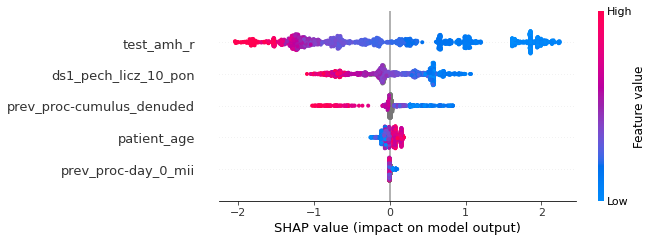

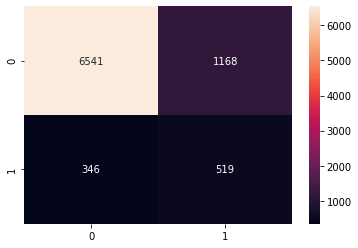

-----------------------
TEST
Confusion Matrix
[[6541 1168]
 [ 346  519]]
Classification Report
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      7709
           1       0.31      0.60      0.41       865

    accuracy                           0.82      8574
   macro avg       0.63      0.72      0.65      8574
weighted avg       0.88      0.82      0.85      8574

Accuracy = 0.8234196407744343
AUC = 0.8382530140808319


<AxesSubplot:xlabel='cumulus_count', ylabel='prediction_h20'>

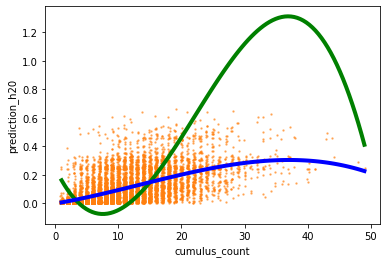

In [142]:
train_cols = [
        "test_amh_r",
        "patient_age",
        "ds1_pech_licz_10_pon",
        "prev_proc-cumulus_denuded",
        "prev_proc-day_0_mii",
        #'cause_pco'
    ]

GENE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES_2015,
    train_cols,
    model_suffixes_filter=['h20'])
GENE_RESULTS.print_errors(
    [GENE_RESULTS],
    print_suffixes=['h20'],
    print_avg=True,
)
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('day_0_mii').copy()
GENE_RESULTS_df['error'] = GENE_RESULTS_df['hiper_20']-GENE_RESULTS_df['prediction_h20']
GENE_RESULTS_df = GENE_RESULTS.get_merged_test_dfs_from_folds('day_0_mii').copy()
fpr, tpr, thresholds = roc_curve(GENE_RESULTS_df['hiper_20'],GENE_RESULTS_df['prediction_h20'], pos_label=1)
print('AUC:{}'.format(auc(fpr, tpr)))
explainer = shap.TreeExplainer(GENE_RESULTS.train_infos['day_0_mii'].fold_infos[0].lgb_models['h20'])
shap_values = explainer.shap_values(GENE_RESULTS.train_infos['day_0_mii'].fold_infos[0].test_df[train_cols])
shap.summary_plot(shap_values[0], GENE_RESULTS.train_infos['day_0_mii'].fold_infos[0].test_df[train_cols])
y_tests = GENE_RESULTS_df['hiper_20']
y_predicted_test = (GENE_RESULTS_df['prediction_h20']>0.2)*1
predictions_test = GENE_RESULTS_df['prediction_h20']
c = confusion_matrix(y_tests, y_predicted_test)
df_cm = pd.DataFrame(c)
sns.heatmap(c, annot=True, fmt='g')
plt.show()
print('-----------------------')
print('TEST')
print('Confusion Matrix')
print(confusion_matrix(y_tests, y_predicted_test))
print('Classification Report')
print(classification_report(y_tests, y_predicted_test))
print('Accuracy = '+ str(accuracy_score(y_tests, y_predicted_test)))
print('AUC = {}'.format(auc(fpr, tpr)))

sns.regplot(
    y="hiper_20", 
    x="cumulus_count",    
    data=GENE_RESULTS_df,
    x_jitter=.2,
    ci = 1,
    scatter_kws={"s": 0,
    'alpha':0.5},
    line_kws={'lw':4,
    'color':'green'},
    order=3)
sns.regplot(
    y="prediction_h20", 
    x="cumulus_count",    
    data=GENE_RESULTS_df,
    x_jitter=.2,
    ci = 1,
    scatter_kws={"s": 2,
    'alpha':0.5},
    line_kws={'lw':4,
    'color':'blue'},
    order=3)

In [126]:
(data_2015_df['hiper_20']==0).sum()/(data_2015_df['hiper_20']==1).sum()

7.108176100628931

In [137]:
(data_2015_df['cause_pco']==True).sum()

580

In [136]:
data_2015_df['cause_pco']

1949     False
10008    False
10009    False
10070    False
241      False
         ...  
5800     False
5801     False
5802     False
5803     False
5804     False
Name: cause_pco, Length: 12892, dtype: category
Categories (2, object): [False, True]

<AxesSubplot:>

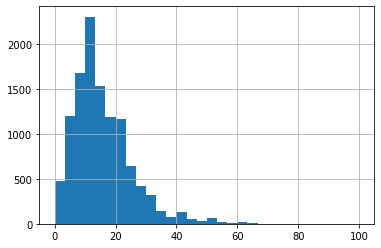

In [139]:
data_2015_df['ds1_pech_licz_10_pon'].hist(bins=30)

<AxesSubplot:>

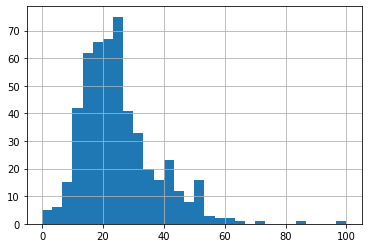

In [140]:
data_2015_df['ds1_pech_licz_10_pon'].loc[data_2015_df['cause_pco']==True].hist(bins=30)

<AxesSubplot:>

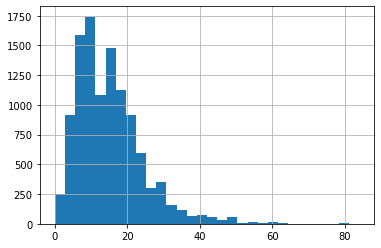

In [141]:
data_2015_df['ds1_pech_licz_10_pon'].loc[data_2015_df['cause_pco']==False].hist(bins=30)

<AxesSubplot:xlabel='cumulus_count', ylabel='ds1_pech_licz_10_pon'>

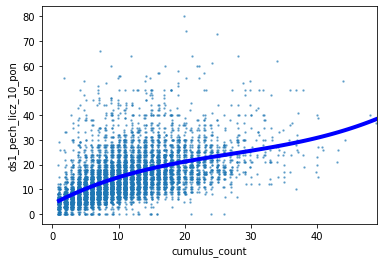

In [143]:
sns.regplot(
    y="ds1_pech_licz_10_pon", 
    x="cumulus_count",    
    data=GENE_RESULTS_df,
    x_jitter=.2,
    ci = 1,
    scatter_kws={"s": 2,
    'alpha':0.5},
    line_kws={'lw':4,
    'color':'blue'},
    order=3)
    

<AxesSubplot:xlabel='cumulus_count', ylabel='test_amh_r'>

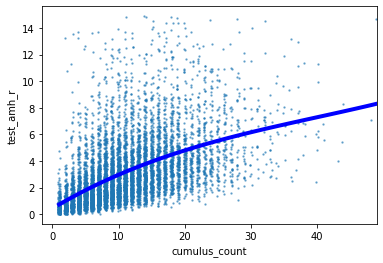

In [144]:
sns.regplot(
    y="test_amh_r", 
    x="cumulus_count",    
    data=GENE_RESULTS_df,
    x_jitter=.2,
    ci = 1,
    scatter_kws={"s": 2,
    'alpha':0.5},
    line_kws={'lw':4,
    'color':'blue'},
    order=3)

In [148]:
(data_2015_df.loc[(data_2015_df['dslast_pech_licz']>10)&(data_2015_df['day_0_mii']<3)]['cause_pco']==True).sum()

13

In [149]:
(data_2015_df.loc[(data_2015_df['dslast_pech_licz']>10)&(data_2015_df['day_0_mii']<3)]['cause_pco']==True).shape

(205,)